In [7]:
import noise_calc
import prop_simulate
import prop_design
import optimization_NSGA2
# import xfoil_interface
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [3]:
Diameter_m = 3;
SpinnerCutoff = 0.2
NumberOfBlades = 2
ObjectiveThrust_N = 4000
AxialVelocity_m_s = 0
ClPolar = "ClarkYAutoClPolar4.dat"
CdPolar = "ClarkYAutoCdPolar4.dat"
NumberOfStations = 11
Convergence = 0.001 #Newton

DistanceToObserver_m = 150
AngleToObserver_deg = 30    #Angle from Negative thrust to observer

In [4]:
def Evaluation(Chromossome):

    Croot_adim = Chromossome["Croot"]
    Cmax_adim = Chromossome["Cmax"]
    Smax_adim = Chromossome["Smax"]
    Ctip_adim = Chromossome["Ctip"]
    Pitch_m = Chromossome["Pitch"]
    Colective_deg = Chromossome["Collective"]

    #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
    a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
    b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
    c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
    d = Croot_adim**2

    S = np.linspace(0, 0.9999, NumberOfStations, endpoint = True)
    RadialStations_adim = [SpinnerCutoff + ((1 - SpinnerCutoff)*s) for s in S]
    RadialStations_m = [r*Diameter_m/2 for r in RadialStations_adim]

    ChordDistribution_m = [((a*s**3 + b*s**2 + c*s + d)**0.5)*Diameter_m/2 for s in S]

    TwistDistribution_deg = prop_design.simple_pitch(RadialStations_m, Pitch_m)
    TwistDistributionCollective_deg = [twist + Colective_deg for twist in TwistDistribution_deg]

    UpperOmega_rad_s = 250
    LowerOmega_rad_s = 10

    dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolars(AxialVelocity_m_s, UpperOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, CLPolar = ClPolar, CDPolar = CdPolar)
    UpperResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)
    dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolars(AxialVelocity_m_s, LowerOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, CLPolar = ClPolar, CDPolar = CdPolar)
    LowerResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)

    # CurrentOmega_rad_s = 200
    Converged = False
    for _ in range(500):

        MidOmega_rad_s = (UpperOmega_rad_s + LowerOmega_rad_s)/2
        dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolars(AxialVelocity_m_s, MidOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, CLPolar = ClPolar, CDPolar = CdPolar)
        MidResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)

        if abs(MidResidue) < Convergence:
            Converged = True
            # print("===================================================================================================")
            break

        if UpperResidue*MidResidue < 0:
            LowerResidue = MidResidue
            LowerOmega_rad_s = MidOmega_rad_s
        elif LowerResidue*MidResidue < 0:
            UpperResidue = MidResidue
            UpperOmega_rad_s = MidOmega_rad_s
        else:
            print("Convergence Failed")
            break
    
    if not Converged:
        return [0.0001, 1]
    
    SoundBand = noise_calc.OneThirdSpectrum()
    BladeArea_m2 = np.trapz(ChordDistribution_m, RadialStations_m)
    AverageBladeCl = sum(Cl_vector)/len(Cl_vector)
    TotalThrust_N = np.trapz(dT_vector, r_vector)
    TotalTorque_Nm = np.trapz(dQ_vector, r_vector)
    TipSpeed_m_s = MidOmega_rad_s*Diameter_m/2

    Bands_Hz, SPL_dB = noise_calc.BroadbandNoise(BladeArea_m2, AverageBladeCl, TotalThrust_N, TipSpeed_m_s, DistanceToObserver_m, AngleToObserver_deg)
    SoundBand.SumToSpectrum(Bands_Hz, SPL_dB)

    return [TotalTorque_Nm*MidOmega_rad_s, SoundBand.AWeightedOASPL()]

def Validation(Chromossome):
    
    Croot_adim = Chromossome["Croot"]
    Cmax_adim = Chromossome["Cmax"]
    Smax_adim = Chromossome["Smax"]
    Ctip_adim = Chromossome["Ctip"]
    Pitch_m = Chromossome["Pitch"]
    Colective_deg = Chromossome["Collective"]

    #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
    a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
    b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
    c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
    d = Croot_adim**2

    DerivativeZero = c/(2*(d**0.5))
    if DerivativeZero < 0:
        return False
    DerivativeOne = (3*a + 2*b + c)/(2*((a + b + c + d)**0.5))
    if DerivativeOne > 0:
        return False
    return True

In [14]:
OptimizationObject = optimization_NSGA2.NSGA2_v2(n_ind = 30, mut_rate = 0.35, t_size = 2, DecimalPoints = 4, convergence = 30, ma_len = 1, ma_tol = 0.001)
OptimizationObject.set_functions(Evaluation, Validation)
OptimizationObject.set_population_limits({"Croot": [0.02, 0.3], "Cmax": [0.02, 0.4], "Smax": [0.0001, 0.9999], "Ctip": [0.02, 0.4], "Pitch": [0.1*Diameter_m, 2*Diameter_m], "Collective": [0, 30]})
OptimizationObject.run()

Geração 1
Moving Average = 4584577.025747996
Geração 2
Moving Average = 4584577.025747996
Geração 3
Moving Average = 4593627.681506462
Geração 4
Moving Average = 4064161.042627901
Geração 5
Moving Average = 3524572.588910546
Geração 6
Moving Average = 4105355.4283721633
Geração 7
Moving Average = 4696048.711726896
Geração 8
Moving Average = 4683367.320504732
Geração 9
Moving Average = 4661973.526108403
Geração 10
Moving Average = 4662177.169172234
Geração 11
Moving Average = 4662254.069201593
Geração 12
Moving Average = 4762263.885092992
Geração 13
Moving Average = 4243288.985968969
Geração 14
Moving Average = 3624554.459499686
Geração 15
Moving Average = 3521336.201337995
Geração 16
Moving Average = 3417493.8253432494
Geração 17
Moving Average = 3475421.995588405
Geração 18
Moving Average = 3536704.3264163584
Geração 19
Moving Average = 3539684.4191080867
Geração 20
Moving Average = 3585595.141643538
Geração 21
Moving Average = 3630446.618536097
Geração 22
Moving Average = 3652905.464

KeyboardInterrupt: 

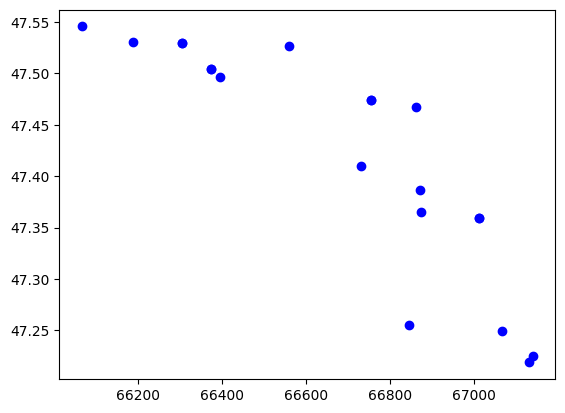

In [8]:
MinOASPL = math.inf
MinPower = math.inf
for individual in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
    funcs = Evaluation(individual.get_chrom())
    if funcs[0] < MinPower:
        MinPower = funcs[0]
        MinPowerIndividual = individual
    if funcs[1] < MinOASPL:
        MinOASPL = funcs[1]
        MinOASPLIndividual = individual
    plt.plot(funcs[0], funcs[1], 'bo')
plt.legend()
plt.show()

In [11]:
S = np.linspace(0, 1, NumberOfStations, endpoint = True)

Chromossome = MinOASPLIndividual.get_chrom()
Croot_adim = Chromossome["Croot"]
Cmax_adim = Chromossome["Cmax"]
Smax_adim = Chromossome["Smax"]
Ctip_adim = Chromossome["Ctip"]
Pitch_m = Chromossome["Pitch"]
Colective_deg = Chromossome["Collective"]
#c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
d = Croot_adim**2
plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S], label = "Minimum Noise")

Chromossome = MinPowerIndividual.get_chrom()
Croot_adim = Chromossome["Croot"]
Cmax_adim = Chromossome["Cmax"]
Smax_adim = Chromossome["Smax"]
Ctip_adim = Chromossome["Ctip"]
Pitch_m = Chromossome["Pitch"]
Colective_deg = Chromossome["Collective"]
#c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
d = Croot_adim**2
plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S], label = "Minimum Power")

a: 0.0953385085347853
b: -0.27047417279659863
c: 0.22168246426181337
d: 0.00041208999999999994

